In [1]:
import importlib
import sys

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
import networkx as nx
import torch_geometric as pyg

import LPGNN

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-06 00:50:05.063779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 00:50:05.063804: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [57]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.embedding)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.graph_metrics)
importlib.reload(LPGNN.DataSetup)
importlib.reload(LPGNN.tree_pruning)
importlib.reload(LPGNN.LinkPrediction)

<module 'LPGNN.LinkPrediction' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/LinkPrediction.py'>

### In the following test, we compare PR curves with LaBNE vs. Poincare Embeddings w/ a prior LaBNE positioning. This is done on a PS network.

In [36]:
def full_test(test_ratio=0.1, chunk_size=10000, step_size=10, EPOCHS = [0, 100, 5000, 10000, 50000, 100000], LaBNE_prior=True):
    PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T, seed, normalize_radius=False)
    print(PS)
    while 1:
        PS = LPGNN.DataSetup.train_test_split(PS, test_ratio=test_ratio, val_ratio=0, neg_samples=False)
        PS_nx = nx.from_edgelist(PS.train_pos_edge_label_index.T.detach().numpy())
        if nx.is_connected(PS_nx):
            print('Train is connected: ', nx.is_connected(PS_nx))
            break
    
    # non normalized radius
    PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=False)
    R_LaBNE_non_norm, P_LaBNE_non_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_{N}_{avg_k}_{gamma}_{T}_{seed}', chunk_size=chunk_size, skip_file_prep=False, step_size=step_size)
    print(" | len: ", R_LaBNE_non_norm.__len__(), P_LaBNE_non_norm.__len__())

    # normalized radius
    PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=0.5)
    R_LaBNE_norm, P_LaBNE_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_{N}_{avg_k}_{gamma}_{T}_{seed}', chunk_size=chunk_size, skip_file_prep=False, step_size=step_size)
    print(" | len: ", R_LaBNE_norm.__len__(), P_LaBNE_norm.__len__())

    R_Poincare = []
    P_Poincare = []

    for epochs in EPOCHS:
        PS_Poincare = PS_LaBNE.clone()
        #r, theta = PS_Poincare.LaBNE_node_polar_positions[:, 0], PS_Poincare.LaBNE_node_polar_positions[:, 1]
        #r = r / r.max() * 0.5
        #PS_Poincare.LaBNE_node_polar_positions[:,0] = r
        #x, y = r * th.cos(theta), r * th.sin(theta)
        #PS_Poincare.LaBNE_node_positions = th.stack([x, y], dim=1)
        if LaBNE_prior: init_pos = PS_Poincare.LaBNE_node_positions
        else: init_pos = None
        PS_Poincare = LPGNN.poincare_embedding.poincare_embedding(PS_Poincare, edge_index='train_pos_edge_label_index', epochs=epochs, lr=0.03, init_pos=init_pos)
        # rescale radius
        r = PS_Poincare.PoincareEmbedding_node_polar_positions[:, 0]
        r = r / r.max() * np.log(N) * 2
        PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
        R, P = LPGNN.LinkPrediction.precision_recall_score_file(PS_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename=f'data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_{N}_{avg_k}_{gamma}_{T}_{seed}_{epochs}', chunk_size=chunk_size, skip_file_prep=False, step_size=step_size)
        R_Poincare.append(R)
        P_Poincare.append(P)
        print(" | len: ", R.__len__(), P.__len__())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(f'PS: N={N}, avg_k={avg_k}, gamma={gamma}, T={T}, seed={seed}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(alpha=0.5)

    for i, epochs in enumerate(EPOCHS):
        ax.plot(R_Poincare[i], P_Poincare[i], label=f'PE ({epochs} epochs)')
    ax.plot(R_LaBNE_non_norm, P_LaBNE_non_norm, label='LaBNE non norm', c='r', linestyle='--')
    ax.plot(R_LaBNE_norm, P_LaBNE_norm, label='LaBNE norm', c='g', linestyle='--')

    ax.legend()

    return fig, ax

### As expected, with epochs close to 0 the results are very similar to LaBNE, since very few updates have been performed.

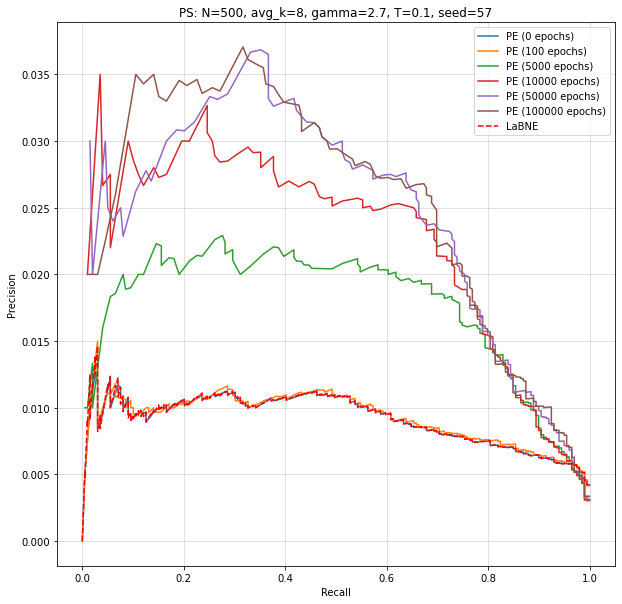

In [113]:
N = 500
avg_k = 8
gamma = 2.7
T = 0.1
seed = 57
fig, ax = full_test()

Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(1998.)  . Total test edges:  1998
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_5000_8_2.7_0.1_456
Sorting file...
Reading file and generating precision-recall curve...
index: 7300000, R: 1.000, P: 0.000731 731


100%|██████████| 10000/10000 [00:12<00:00, 770.40it/s]


Generating test mask...
Total test mask:  tensor(1998.)  . Total test edges:  1998
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_5000_8_2.7_0.1_456_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 9490000, R: 1.000, P: 0.000950 950


100%|██████████| 50000/50000 [01:15<00:00, 664.00it/s]


Generating test mask...
Total test mask:  tensor(1998.)  . Total test edges:  1998
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_5000_8_2.7_0.1_456_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 9880000, R: 1.000, P: 0.000989 989


100%|██████████| 100000/100000 [02:13<00:00, 749.69it/s]


Generating test mask...
Total test mask:  tensor(1998.)  . Total test edges:  1998
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_5000_8_2.7_0.1_456_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 12490000, R: 1.000, P: 0.0001250 1250


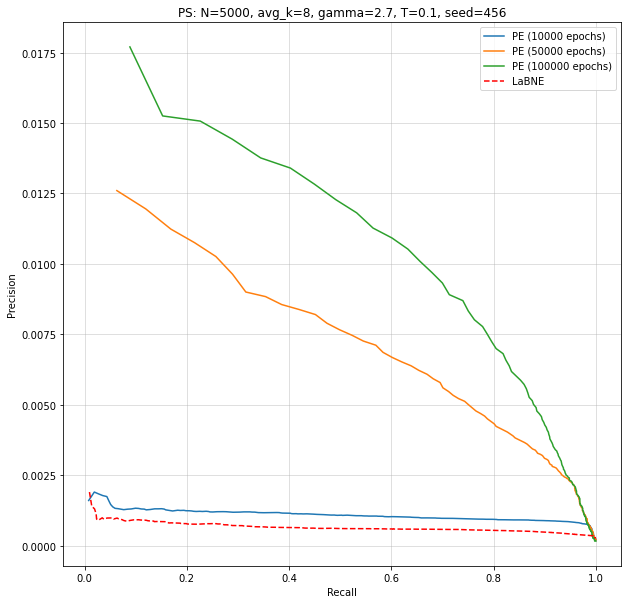

In [4]:
N = 5000
avg_k = 8
gamma = 2.7
T = 0.1
seed = 456
fig, ax = full_test(chunk_size=20000, step_size=10000, EPOCHS=[10000, 50000, 100000])

Data(is_directed=False, is_PS=True, num_nodes=8000, avg_k=8, gamma=2.7, T=0.3, seed=456, node_polar_positions=[8000, 2], edge_index=[2, 63980], node_positions=[8000, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(12796.)  . Total test edges:  12796
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_8000_8_2.7_0.3_456
Sorting file...
Reading file and generating precision-recall curve...
index: 31960000, R: 1.000, P: 0.0001599 1599


100%|██████████| 10000/10000 [00:15<00:00, 656.80it/s]


Generating test mask...
Total test mask:  tensor(12796.)  . Total test edges:  12796
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_8000_8_2.7_0.3_456_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 31940000, R: 1.000, P: 0.0001598 1598


100%|██████████| 50000/50000 [01:14<00:00, 673.04it/s]


Generating test mask...
Total test mask:  tensor(12796.)  . Total test edges:  12796
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_8000_8_2.7_0.3_456_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 31960000, R: 1.000, P: 0.0001599 1599


100%|██████████| 100000/100000 [02:29<00:00, 669.58it/s]


Generating test mask...
Total test mask:  tensor(12796.)  . Total test edges:  12796
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_8000_8_2.7_0.3_456_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 31980000, R: 1.000, P: 0.0001600 1600


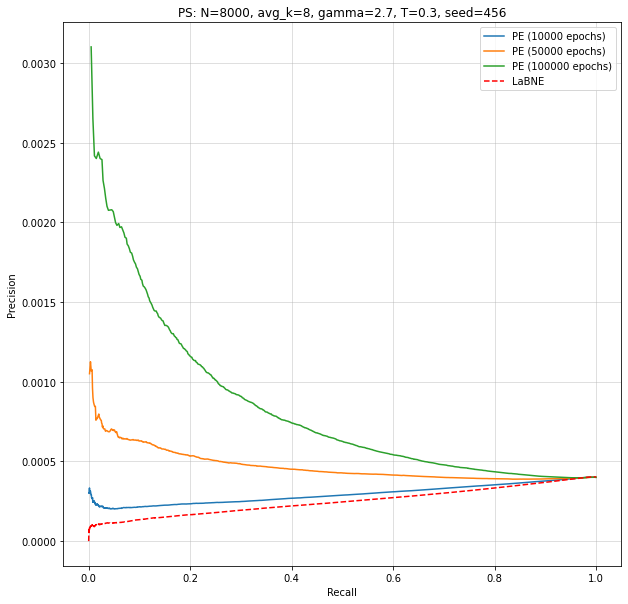

In [10]:
N = 8000
avg_k = 8
gamma = 2.7
T = 0.3
seed = 456
fig, ax = full_test(test_ratio=0.4, chunk_size=30000, step_size=20000, EPOCHS=[10000, 50000, 100000])

Data(is_directed=False, is_PS=True, num_nodes=600, avg_k=6, gamma=2.2, T=0.3, seed=45, node_polar_positions=[600, 2], edge_index=[2, 3588], node_positions=[600, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(717.)  . Total test edges:  717
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_600_6_2.2_0.3_45
Sorting file...
Reading file and generating precision-recall curve...
index: 177800, R: 1.000, P: 0.004890 890


100%|██████████| 10000/10000 [00:12<00:00, 799.65it/s]


Generating test mask...
Total test mask:  tensor(717.)  . Total test edges:  717
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_600_6_2.2_0.3_45_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 179600, R: 1.000, P: 0.004899 899


100%|██████████| 50000/50000 [00:59<00:00, 836.40it/s]


Generating test mask...
Total test mask:  tensor(717.)  . Total test edges:  717
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_600_6_2.2_0.3_45_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 179600, R: 1.000, P: 0.004899 899


100%|██████████| 100000/100000 [02:00<00:00, 826.52it/s]


Generating test mask...
Total test mask:  tensor(717.)  . Total test edges:  717
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_600_6_2.2_0.3_45_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 179600, R: 1.000, P: 0.004899 899


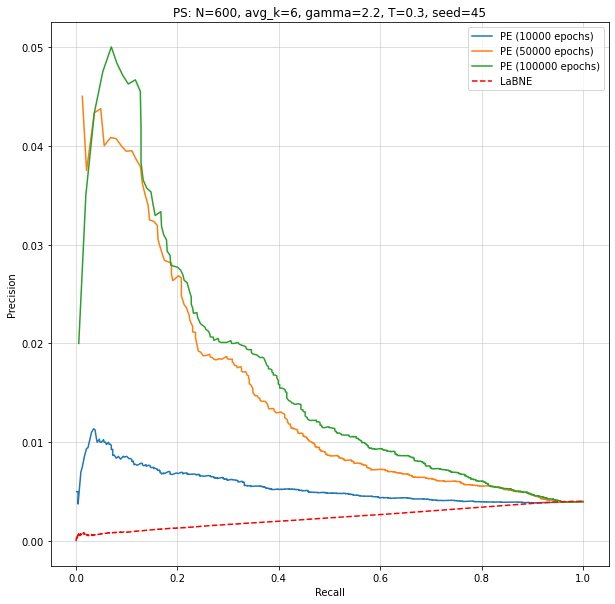

In [11]:
N = 600
avg_k = 6
gamma = 2.2
T = 0.3
seed = 45
fig, ax = full_test(test_ratio=0.4, chunk_size=3000, step_size=200, EPOCHS=[10000, 50000, 100000])

Data(is_directed=False, is_PS=True, num_nodes=800, avg_k=12, gamma=2.2, T=0.04, seed=45, node_polar_positions=[800, 2], edge_index=[2, 9558], node_positions=[800, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(238.)  . Total test edges:  238
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_800_12_2.2_0.04_45
Sorting file...
Reading file and generating precision-recall curve...
index: 160400, R: 1.000, P: 0.001803 803


100%|██████████| 10000/10000 [00:10<00:00, 917.81it/s]


Generating test mask...
Total test mask:  tensor(238.)  . Total test edges:  238
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_800_12_2.2_0.04_45_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 264800, R: 1.000, P: 0.0011325 1325


100%|██████████| 50000/50000 [00:53<00:00, 925.97it/s] 


Generating test mask...
Total test mask:  tensor(238.)  . Total test edges:  238
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_800_12_2.2_0.04_45_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 256400, R: 1.000, P: 0.0011283 1283


100%|██████████| 200000/200000 [03:37<00:00, 920.20it/s] 


Generating test mask...
Total test mask:  tensor(238.)  . Total test edges:  238
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_800_12_2.2_0.04_45_200000
Sorting file...
Reading file and generating precision-recall curve...
index: 234600, R: 1.000, P: 0.0011174 1174


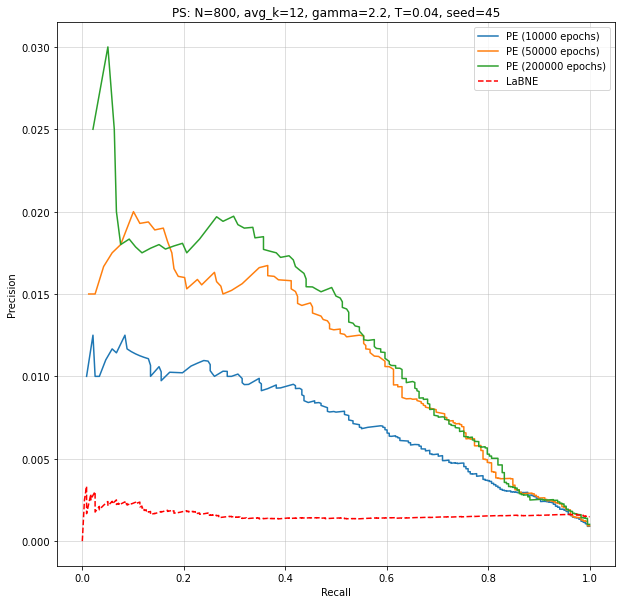

In [12]:
N = 800
avg_k = 12
gamma = 2.2
T = 0.04
seed = 45
fig, ax = full_test(test_ratio=0.05, chunk_size=3000, step_size=200, EPOCHS=[10000, 50000, 200000])

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=18, gamma=2.4, T=0.0, seed=450, node_polar_positions=[500, 2], edge_index=[2, 8910], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2227.)  . Total test edges:  2227
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_500_18_2.4_0.0_450
Sorting file...
Reading file and generating precision-recall curve...
index: 67200, R: 1.000, P: 0.033337 337


100%|██████████| 10000/10000 [00:10<00:00, 909.91it/s]


Generating test mask...
Total test mask:  tensor(2227.)  . Total test edges:  2227
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_18_2.4_0.0_450_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 119200, R: 1.000, P: 0.019597 597


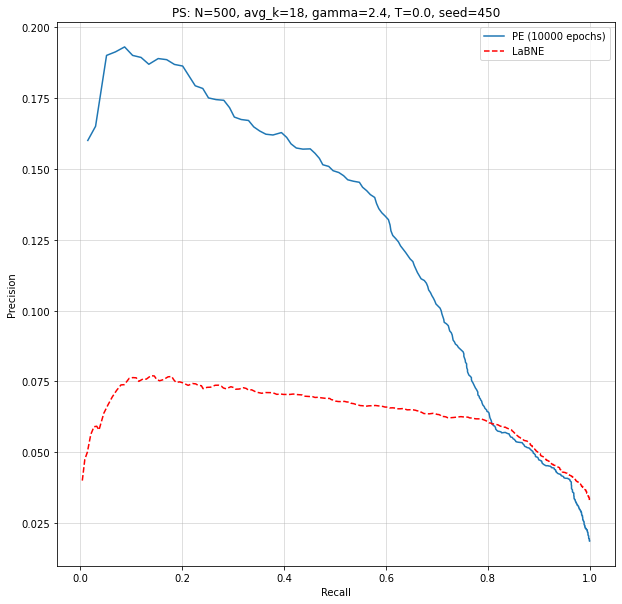

In [14]:
N = 500
avg_k = 18
gamma = 2.4
T = 0.0
seed = 450
fig, ax = full_test(test_ratio=0.5, chunk_size=3000, step_size=200, EPOCHS=[10000])

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=40, gamma=2.4, T=0.0, seed=450, node_polar_positions=[500, 2], edge_index=[2, 19580], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_500_40_2.4_0.0_450
Sorting file...
Reading file and generating precision-recall curve...
index: 76800, R: 1.000, P: 0.064385 385


100%|██████████| 1000/1000 [00:01<00:00, 834.07it/s]


Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_40_2.4_0.0_450_1000
Sorting file...
Reading file and generating precision-recall curve...
index: 72600, R: 1.000, P: 0.067364 364


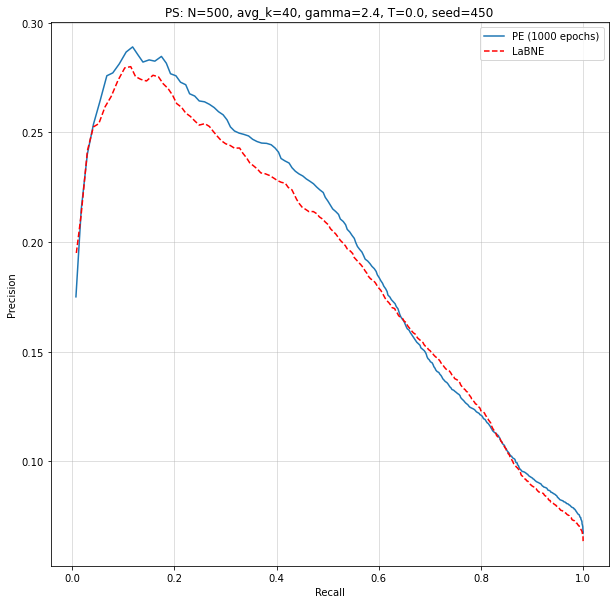

In [15]:
N = 500
avg_k = 40
gamma = 2.4
T = 0.0
seed = 450
fig, ax = full_test(test_ratio=0.5, chunk_size=3000, step_size=200, EPOCHS=[1000])

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=40, gamma=2.4, T=0.5, seed=450, node_polar_positions=[500, 2], edge_index=[2, 19580], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_500_40_2.4_0.5_450
Sorting file...
Reading file and generating precision-recall curve...
index: 121000, R: 1.000, P: 0.040606 606


100%|██████████| 20000/20000 [00:22<00:00, 888.17it/s] 


Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_40_2.4_0.5_450_20000
Sorting file...
Reading file and generating precision-recall curve...
index: 123600, R: 1.000, P: 0.040619 619


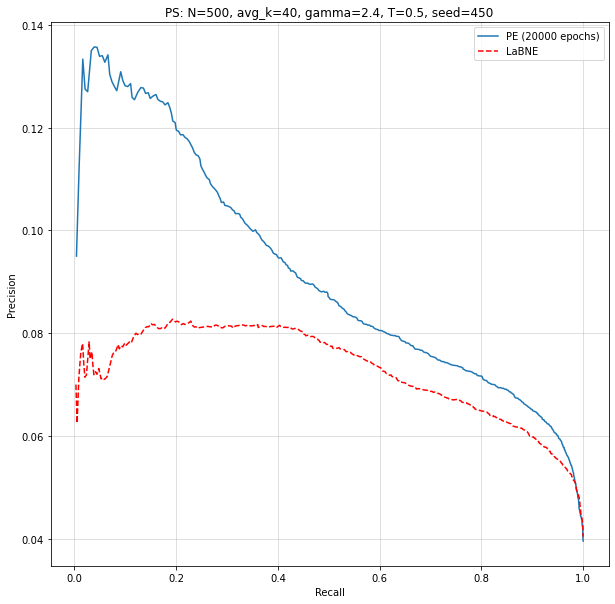

In [16]:
N = 500
avg_k = 40
gamma = 2.4
T = 0.5
seed = 450
fig, ax = full_test(test_ratio=0.5, chunk_size=3000, step_size=200, EPOCHS=[20000])

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=40, gamma=2.4, T=0.5, seed=450, node_polar_positions=[500, 2], edge_index=[2, 19580], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_500_40_2.4_0.5_450
Sorting file...
Reading file and generating precision-recall curve...
index: 249400, R: 2.000, P: 0.0391248 1248


100%|██████████| 20000/20000 [00:22<00:00, 875.49it/s] 


Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_40_2.4_0.5_450_20000
Sorting file...
Reading file and generating precision-recall curve...
index: 249400, R: 2.000, P: 0.0391248 1248


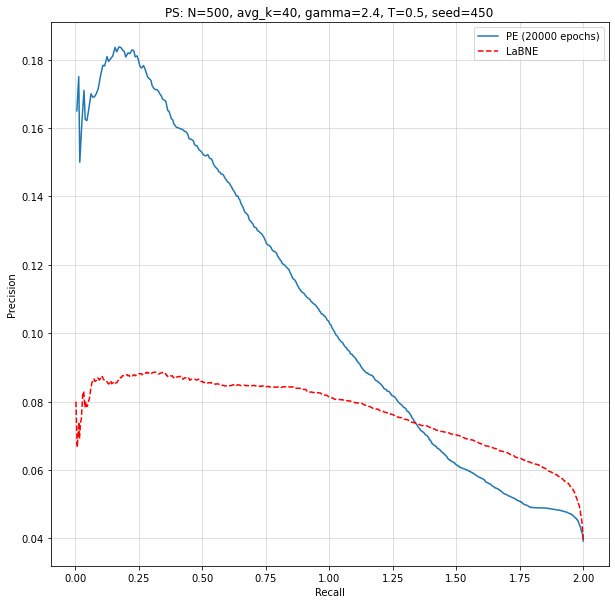

In [18]:
N = 500
avg_k = 40
gamma = 2.4
T = 0.5
seed = 450
fig, ax = full_test(test_ratio=0.5, chunk_size=3000, step_size=200, EPOCHS=[20000], LaBNE_prior=False)

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=20, gamma=2.4, T=0.01, seed=999, node_polar_positions=[500, 2], edge_index=[2, 9890], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_500_20_2.4_0.01_999
Sorting file...
Reading file and generating precision-recall curve...
index: 86800, R: 1.000, P: 0.028435 435
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_500_20_2.4_0.01_999
Sorting file...
Reading file and generating precision-recall curve...
index: 70600, R: 1.000, P: 0.035354 354


100%|██████████| 10000/10000 [00:10<00:00, 918.67it/s]


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_20_2.4_0.01_999_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 104000, R: 1.000, P: 0.024521 521


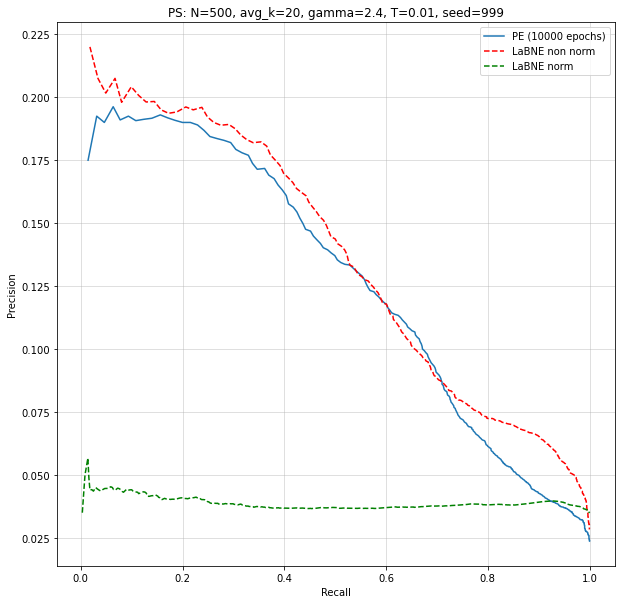

In [23]:
N = 500
avg_k = 20
gamma = 2.4
T = 0.01
seed = 999
fig, ax = full_test(test_ratio=0.5, chunk_size=3000, step_size=200, EPOCHS=[10000], LaBNE_prior=False)

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=20, gamma=2.4, T=0.0, seed=666, node_polar_positions=[500, 2], edge_index=[2, 9890], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_500_20_2.4_0.0_666
Sorting file...
Reading file and generating precision-recall curve...
index: 53900, R: 1.000, P: 0.046 | len:  540 540
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_500_20_2.4_0.0_666
Sorting file...
Reading file and generating precision-recall curve...
index: 76900, R: 1.000, P: 0.032 | len:  770 770


100%|██████████| 10000/10000 [00:10<00:00, 969.45it/s]


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_20_2.4_0.0_666_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 107200, R: 1.000, P: 0.023 | len:  1073 1073


100%|██████████| 50000/50000 [00:52<00:00, 960.77it/s] 


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_20_2.4_0.0_666_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 99700, R: 1.000, P: 0.025 | len:  998 998


100%|██████████| 100000/100000 [01:44<00:00, 961.36it/s]


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_500_20_2.4_0.0_666_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 93900, R: 1.000, P: 0.026 | len:  940 940


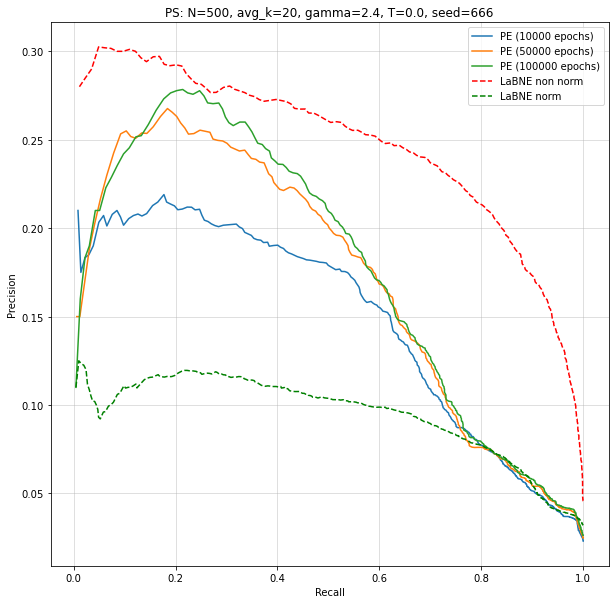

In [27]:
N = 500
avg_k = 20
gamma = 2.4
T = 0.0
seed = 666
fig, ax = full_test(test_ratio=0.5, chunk_size=10000, step_size=100, EPOCHS=[10000, 50000, 100000], LaBNE_prior=True)

# Up until now, all Poincaré embeddings have been left at radius 1. We now test the effect of changing the radius, _after_ the embedding has been trained. This means that the rescaling is for the distance calculation only, and not for the embedding itself.

Data(is_directed=False, is_PS=True, num_nodes=500, avg_k=20, gamma=2.4, T=0.0, seed=666, node_polar_positions=[500, 2], edge_index=[2, 9890], node_positions=[500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_500_20_2.4_0.0_666
Sorting file...
Reading file and generating precision-recall curve...
index: 53900, R: 1.000, P: 0.046 | len:  540 540
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_500_20_2.4_0.0_666
Sorting file...
Reading file and generating precision-recall curve...
index: 76900, R: 1.000, P: 0.032 | len:  770 770


100%|██████████| 10000/10000 [00:10<00:00, 931.43it/s]


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_500_20_2.4_0.0_666_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 76900, R: 1.000, P: 0.032 | len:  770 770


100%|██████████| 50000/50000 [00:51<00:00, 970.02it/s] 


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_500_20_2.4_0.0_666_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 64200, R: 1.000, P: 0.038 | len:  643 643


100%|██████████| 100000/100000 [01:44<00:00, 957.49it/s]


Generating test mask...
Total test mask:  tensor(2472.)  . Total test edges:  2472
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_500_20_2.4_0.0_666_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 54600, R: 1.000, P: 0.045 | len:  547 547


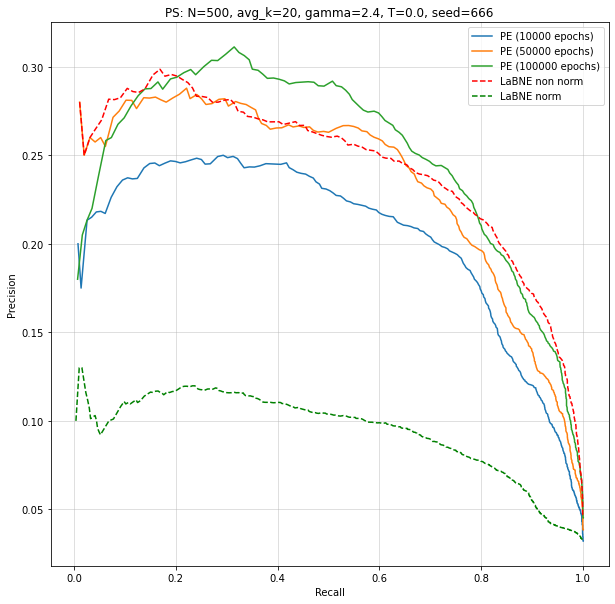

In [37]:
N = 500
avg_k = 20
gamma = 2.4
T = 0.0
seed = 666
fig, ax = full_test(test_ratio=0.5, chunk_size=10000, step_size=100, EPOCHS=[10000, 50000, 100000], LaBNE_prior=True)

Data(is_directed=False, is_PS=True, num_nodes=1100, avg_k=8, gamma=2.4, T=0.2, seed=777, node_polar_positions=[1100, 2], edge_index=[2, 8780], node_positions=[1100, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2195.)  . Total test edges:  2195
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_1100_8_2.4_0.2_777
Sorting file...
Reading file and generating precision-recall curve...
index: 599500, R: 1.000, P: 0.004 | len:  1200 1200
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2195.)  . Total test edges:  2195
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_1100_8_2.4_0.2_777
Sorting file...
Reading file and generating precision-recall curve...
index: 601500, R: 1.000, P: 0.004 | len:  1204 1204


100%|██████████| 10000/10000 [00:12<00:00, 788.65it/s]


Generating test mask...
Total test mask:  tensor(2195.)  . Total test edges:  2195
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1100_8_2.4_0.2_777_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 602500, R: 1.000, P: 0.004 | len:  1206 1206


100%|██████████| 50000/50000 [01:04<00:00, 776.87it/s]


Generating test mask...
Total test mask:  tensor(2195.)  . Total test edges:  2195
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1100_8_2.4_0.2_777_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 602500, R: 1.000, P: 0.004 | len:  1206 1206


100%|██████████| 100000/100000 [02:04<00:00, 806.38it/s]


Generating test mask...
Total test mask:  tensor(2195.)  . Total test edges:  2195
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1100_8_2.4_0.2_777_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 603500, R: 1.000, P: 0.004 | len:  1208 1208


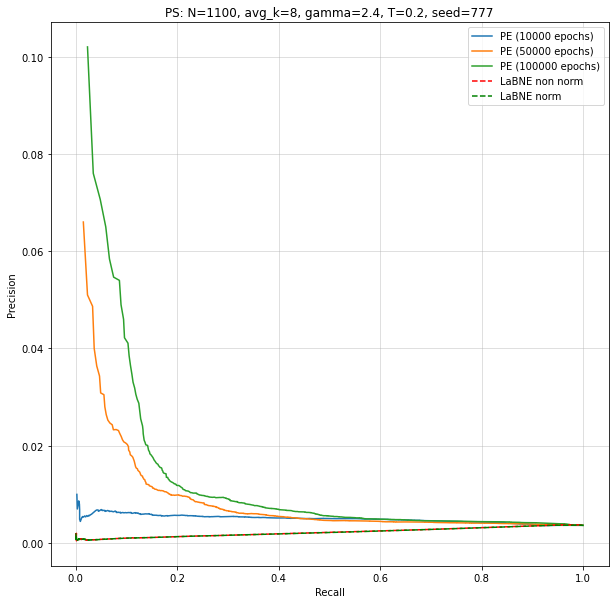

In [38]:
N = 1100
avg_k = 8
gamma = 2.4
T = 0.2
seed = 777
fig, ax = full_test(test_ratio=0.5, chunk_size=10000, step_size=500, EPOCHS=[10000, 50000, 100000], LaBNE_prior=True)

Data(is_directed=False, is_PS=True, num_nodes=900, avg_k=8, gamma=2.4, T=0.2, seed=777, node_polar_positions=[900, 2], edge_index=[2, 7180], node_positions=[900, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(718.)  . Total test edges:  718
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_900_8_2.4_0.2_777
Sorting file...
Reading file and generating precision-recall curve...
index: 379000, R: 1.000, P: 0.002 | len:  759 759
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(718.)  . Total test edges:  718
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_900_8_2.4_0.2_777
Sorting file...
Reading file and generating precision-recall curve...
index: 400000, R: 1.000, P: 0.002 | len:  801 801


100%|██████████| 10000/10000 [00:11<00:00, 895.91it/s]


Generating test mask...
Total test mask:  tensor(718.)  . Total test edges:  718
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_900_8_2.4_0.2_777_10000
Sorting file...
Reading file and generating precision-recall curve...
index: 399500, R: 1.000, P: 0.002 | len:  800 800


100%|██████████| 50000/50000 [00:57<00:00, 865.32it/s] 


Generating test mask...
Total test mask:  tensor(718.)  . Total test edges:  718
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_900_8_2.4_0.2_777_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 379000, R: 1.000, P: 0.002 | len:  759 759


100%|██████████| 100000/100000 [01:46<00:00, 938.30it/s]


Generating test mask...
Total test mask:  tensor(718.)  . Total test edges:  718
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_900_8_2.4_0.2_777_100000
Sorting file...
Reading file and generating precision-recall curve...
index: 362000, R: 1.000, P: 0.002 | len:  725 725


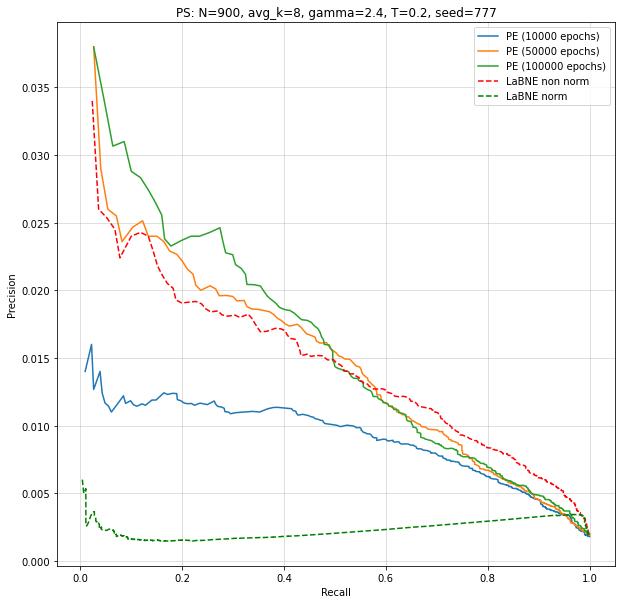

In [58]:
N = 900
avg_k = 8
gamma = 2.4
T = 0.2
seed = 777
fig, ax = full_test(test_ratio=0.2, chunk_size=10000, step_size=500, EPOCHS=[10000, 50000, 100000], LaBNE_prior=True)

Data(is_directed=False, is_PS=True, num_nodes=2000, avg_k=8, gamma=2.4, T=0.2, seed=555, node_polar_positions=[2000, 2], edge_index=[2, 15980], node_positions=[2000, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2397.)  . Total test edges:  2397
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_2000_8_2.4_0.2_555
Sorting file...
Reading file and generating precision-recall curve...
index: 1998500, R: 1.000, P: 0.001 | len:  3998 3998
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2397.)  . Total test edges:  2397
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_2000_8_2.4_0.2_555
Sorting file...
Reading file and generating precision-recall curve...
index: 1998000, R: 1.000, P: 0.001 | len:  3997 3997


100%|██████████| 1000000/1000000 [19:45<00:00, 843.59it/s]


Generating test mask...
Total test mask:  tensor(2397.)  . Total test edges:  2397
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_2000_8_2.4_0.2_555_1000000
Sorting file...
Reading file and generating precision-recall curve...
index: 1988000, R: 1.000, P: 0.001 | len:  3977 3977


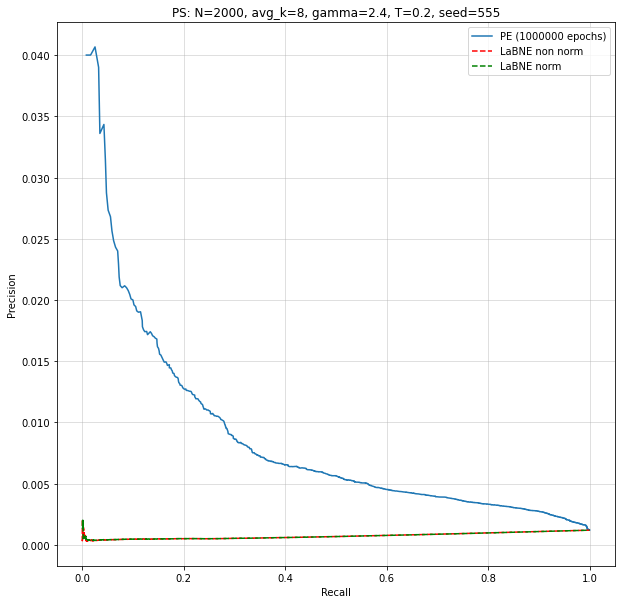

In [59]:
N = 2000
avg_k = 8
gamma = 2.4
T = 0.2
seed = 555
fig, ax = full_test(test_ratio=0.3, chunk_size=10000, step_size=500, EPOCHS=[1000000], LaBNE_prior=True)

Data(is_directed=False, is_PS=True, num_nodes=3000, avg_k=8, gamma=2.4, T=0.2, seed=555, node_polar_positions=[3000, 2], edge_index=[2, 23980], node_positions=[3000, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2398.)  . Total test edges:  2398
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_3000_8_2.4_0.2_555
Sorting file...
Reading file and generating precision-recall curve...
index: 4490500, R: 1.000, P: 0.001 | len:  8982 8982
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(2398.)  . Total test edges:  2398
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_3000_8_2.4_0.2_555
Sorting file...
Reading file and generating precision-recall curve...
index: 4497500, R: 1.000, P: 0.001 | len:  8996 8996


100%|██████████| 1000/1000 [00:01<00:00, 725.24it/s]


Generating test mask...
Total test mask:  tensor(2398.)  . Total test edges:  2398
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_3000_8_2.4_0.2_555_1000
Sorting file...
Reading file and generating precision-recall curve...
index: 4485000, R: 1.000, P: 0.001 | len:  8971 8971


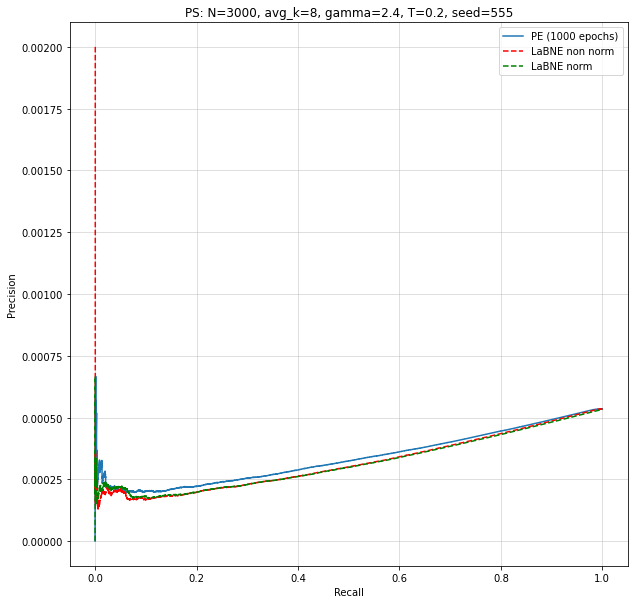

In [60]:
N = 3000
avg_k = 8
gamma = 2.4
T = 0.2
seed = 555
fig, ax = full_test(test_ratio=0.2, chunk_size=10000, step_size=500, EPOCHS=[1000], LaBNE_prior=True)